#Import and Define
Project 2: Time Series Forecasting using NN, LSTM, and CNN

Authors: Jason Phillips and Peeja

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.3 MB/s eta 0:00:00


In [127]:
#Import and print out the current version of packages.
%load_ext tensorboard

import tensorflow as tf
import tf_explain
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn as sk
import pandas as pd
import shutil
import os
import imblearn
import io
import requests
import datetime

from scipy.stats import zscore
from collections.abc import Sequence
from collections import Counter
from numpy import where
from sklearn.datasets import make_classification
from matplotlib import pyplot
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

print('Python {}'.format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print('Tensor Flow {}'.format(tf.__version__))
print('Keras {}'.format(tf.keras.__version__))
print('Imblearn {}'.format(imblearn.__version__))

#Remove any files in the log folder for tensorboard
!rm -rf "/content/drive/MyDrive/Colab Notebooks/logs/"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Python 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
Pandas 1.3.5
Numpy 1.22.4
Scikit-Learn 1.2.1

Tensor Flow 2.11.0
Keras 2.11.0
Imblearn 0.8.1


In [ ]:
#Define the log folder for tensorboard
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Data Preprocessing
Import dataset and preprocess it.

In [370]:
#Create the dataframe and convert empty values to NA
df = pd.read_csv('https://raw.githubusercontent.com/JasonTPhillipsJr/CSC215/main/TSLA.csv', na_values=['NA', '?'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3186,2023-02-24,196.330002,197.669998,192.800003,196.880005,196.880005,142228100
3187,2023-02-27,202.029999,209.419998,201.259995,207.630005,207.630005,161028300
3188,2023-02-28,210.589996,211.229996,203.750000,205.710007,205.710007,153144900
3189,2023-03-01,206.210007,207.199997,198.520004,202.770004,202.770004,156852800


In [371]:
#Check if any values are empty or null
df[df.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume


In [372]:
#Display data types for each column
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [373]:
#Show some statistics for each column.
data = {'Mean': df.mean(),
        'Max': df.max(),
        'Min': df.min(),
        'Variaence': df.var(),
        'STD': df.std()}

dataframe = pd.DataFrame(data)
dataframe

<ipython-input-373-0e371d19d6b4>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = {'Mean': df.mean(),
<ipython-input-373-0e371d19d6b4>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'Variaence': df.var(),
<ipython-input-373-0e371d19d6b4>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'STD': df.std()}


,Mean,Max,Min,Variaence,STD
Adj Close,6.020587e+01,409.970001,1.053333,9.175041e+03,9.578644e+01
Close,6.020587e+01,409.970001,1.053333,9.175041e+03,9.578644e+01
Date,NaN,2023-03-02,2010-06-29,NaN,NaN
High,6.160542e+01,414.496674,1.108667,9.626803e+03,9.811627e+01
Low,5.874202e+01,405.666656,0.998667,8.724170e+03,9.340326e+01
Open,6.023675e+01,411.470001,1.076,9.195453e+03,9.589293e+01
Volume,9.485638e+07,914082000,1777500,6.723681e+15,8.199805e+07


In [374]:
#Drop columns that aren't needed
df = df.drop(['Date', 'Adj Close'], axis=1)
df

,Open,High,Low,Close,Volume
0,1.266667,1.666667,1.169333,1.592667,281494500
1,1.719333,2.028000,1.553333,1.588667,257806500
2,1.666667,1.728000,1.351333,1.464000,123282000
3,1.533333,1.540000,1.247333,1.280000,77097000
4,1.333333,1.333333,1.055333,1.074000,103003500
...,...,...,...,...,...
3186,196.330002,197.669998,192.800003,196.880005,142228100
3187,202.029999,209.419998,201.259995,207.630005,161028300
3188,210.589996,211.229996,203.750000,205.710007,153144900
3189,206.210007,207.199997,198.520004,202.770004,156852800


In [375]:
#Create a copy of the Close column to use for the output feature.
#df['Close_Output'] = df['Close']
#df
df_y = df["Close"]
df_y

0         1.592667
1         1.588667
2         1.464000
3         1.280000
4         1.074000
           ...    
3186    196.880005
3187    207.630005
3188    205.710007
3189    202.770004
3190    190.899994
Name: Close, Length: 3191, dtype: float64

In [376]:
#Normalize the Numeric Data
df['Open'] = zscore(df['Open'])
df['High'] = zscore(df['High'])
df['Low'] = zscore(df['Low'])
df['Close'] = zscore(df['Close'])
df['Volume'] = zscore(df['Volume'])

#Never normalize the output feature when traaining any regression models, else RMSE will also be normalized
#df['Close_Output'] = zscore(df['Close_Output'])
df

,Open,High,Low,Close,Volume
0,-0.615054,-0.610991,-0.616485,-0.612011,2.276485
1,-0.610333,-0.607308,-0.612373,-0.612053,1.987555
2,-0.610882,-0.610366,-0.614536,-0.613355,0.346716
3,-0.612273,-0.612282,-0.615650,-0.615276,-0.216617
4,-0.614359,-0.614389,-0.617706,-0.617427,0.099373
...,...,...,...,...,...
3186,1.419443,1.386986,1.435485,1.427087,0.577808
3187,1.478894,1.506761,1.526074,1.539333,0.807120
3188,1.568174,1.525211,1.552737,1.519285,0.710964
3189,1.522491,1.484131,1.496735,1.488587,0.756190


#Splitting the Data
Create test and training splits with a 30/70 split

Now we have two Dataframes: df and df_y for input/output.
reshape df to be either a sequence of 35 inputs per output or 7 rows by 5 columns per input.

In [377]:
#Setup our Input and ouput features to be of the correct shape.
#We want the first seven rows and 5 columns per prediction. 35 values total
#Since we have 3191 Rows of data. rows/7 = 455 rows as input vectors with 35 values in each vector.
x = []  #input
y = []  #output

i=0
while i in range(len(df)-7-1):
  if i > (len(df)-7-1):
    break
  x_temp = df[i:i+7]
  x.append(x_temp)
  y_temp = df_y.iloc[i+8]   #Note, we take the 8th value instead of the 7th because we are looking at the close for the next day after a week.
  y.append(y_temp)
  i += 7


In [387]:
#Ensure x is of the correct shape
x

array([[-0.615054  , -0.61099085, -0.61648497, ..., -0.61789128,
        -0.61648733,  0.25388261],
       [-0.61604138, -0.61581583, -0.61719169, ..., -0.61407211,
        -0.61338967, -0.70206429],
       [-0.61307232, -0.61313151, -0.61469317, ..., -0.6143648 ,
        -0.61421804, -1.07151511],
       ...,
       [ 0.86321508,  0.8653803 ,  0.88188456, ...,  1.19059439,
         1.26555633,  1.45087056],
       [ 1.325574  ,  1.37760804,  1.32637118, ...,  1.43644881,
         1.42719113,  1.33362379],
       [ 1.39952218,  1.37302096,  1.37991089, ...,  1.42456299,
         1.46864401,  1.18280024]])

In [379]:
#Ensure y is each 8th value from the Close_Output coloumn.
y

[-0.6167727238203756,
 -0.614566084432367,
 -0.6147609964312312,
 -0.615394442154866,
 -0.6155615065991702,
 -0.6148097165998014,
 -0.6142249910447367,
 -0.6139813588773024,
 -0.6133409486546456,
 -0.6144199030436008,
 -0.6146844182665733,
 -0.6138908621561283,
 -0.6112526431008433,
 -0.6081132202711177,
 -0.6047440838304741,
 -0.6061084469394674,
 -0.6068115063287384,
 -0.6093383560488392,
 -0.6089833441046928,
 -0.611913936379038,
 -0.6119278549355541,
 -0.6115937260469457,
 -0.6122132636555924,
 -0.611976585545652,
 -0.6119278549355541,
 -0.612818872266195,
 -0.6121366854909344,
 -0.6102015258249202,
 -0.6111273447676151,
 -0.6094288527700131,
 -0.6089206949380788,
 -0.6090111916592528,
 -0.6076607575483032,
 -0.6094149342134971,
 -0.6105356547135284,
 -0.6089485424926386,
 -0.6089067763815627,
 -0.6086700982716224,
 -0.6090320747147908,
 -0.6111969479917233,
 -0.6117538364337558,
 -0.6114405906006853,
 -0.6122062991565704,
 -0.6107027191578326,
 -0.6115241228228375,
 -0.60985347837

In [380]:
#Ensure we have the right size
print(len(x))
print(len(y))


455
455


In [381]:
#Convert x and y to numpy arrays for tensorflow
#Reshape the arrays to be of the correct size for problem 1.
x = np.array(x)
y = np.array(y)
x = x.reshape(455,35)
y = y.reshape(455,1)


In [382]:
print(x)

[[-0.615054   -0.61099085 -0.61648497 ... -0.61789128 -0.61648733
   0.25388261]
 [-0.61604138 -0.61581583 -0.61719169 ... -0.61407211 -0.61338967
  -0.70206429]
 [-0.61307232 -0.61313151 -0.61469317 ... -0.6143648  -0.61421804
  -1.07151511]
 ...
 [ 0.86321508  0.8653803   0.88188456 ...  1.19059439  1.26555633
   1.45087056]
 [ 1.325574    1.37760804  1.32637118 ...  1.43644881  1.42719113
   1.33362379]
 [ 1.39952218  1.37302096  1.37991089 ...  1.42456299  1.46864401
   1.18280024]]


In [ ]:
"""
#Choose only the 8th input from the output column. After 7 days make a prediction.
y = []
i = 1
counter = 0
while i in range(len(df_y)):
  #print (i)
  
  if(counter == 7):
    #print("i is" + str(i))
    #print("df at i is" + str(df_y[i]))
    counter = 0
    y.append(df_y[i])
  
  counter += 1
  i+=1

y = np.array(y)
y = y.reshape(455,1)
#print(df_y.shape)
print(y.shape)
print(y)

"""   

In [ ]:
"""
x = []
i = 0
df = df.to_numpy()
counter = 0
while i in range(len(df)):
  #print (i)
 
  if(counter == 7):
    #print("i is" + str(i))
    #print("df at i is" + str(df[i]))
    counter = 0
    window = df[i:(i+7)]
    #window = [[x] for x in window]
    #print("{} - {}".format(window,after_window))
    x.append(window)
  
  counter += 1
  i+=1


x = np.array(x)
#print(df.shape)
x = x.reshape(455,35)
print(x.shape)
print(x)
"""

In [ ]:
"""
#Remove the last few rows so that we can have an equal amount of weeks: 7 * 455 = 3185. Add 1 for the last output column value
total_rows = 3186
df = df[0:total_rows]
df_y = df_y[0:total_rows]

print(df.shape)
print(df_y.shape)
"""

In [383]:
#Create the x(inputs) and y(outputs)

#Close_Output = df["Close_Output"]
#x,y = to_xy(df,"Close_Output")

#Split the train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)


In [ ]:
#ratio = 0.70
 
#total_rows = df.shape[0]
#train_size = int(total_rows*ratio)
 
# Split data into test and train
#df_train = df[0:train_size]
#df_test = df[train_size:]

#spots_train = df_train["Close_Output"].tolist()
#spots_test = df_test["Close_Output"].tolist()

#print("Training set has {} records.".format(len(df_train)))
#print("Test set has {} records.".format(len(df_test)))
#print("Shape of df_train: {}".format(df_train.shape))
#print("Shape of df_test: {}".format(df_test.shape))

In [363]:
"""
df_train = df.to_numpy()
df_test = df.to_numpy()
"""

'\ndf_train = df.to_numpy()\ndf_test = df.to_numpy()\n'

In [ ]:
"""
df_train.flatten()
df_test.flatten()
"""

In [ ]:
"""
SEQUENCE_SIZE = 35
x_train,y_train = to_sequences(SEQUENCE_SIZE,df_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,df_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))
"""

In [384]:
print("x shape: " + str(x.shape))
print("y shape: " + str(y.shape))
print()
print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))
print()
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

x shape: (455, 35)
y shape: (455, 1)

x_train shape: (318, 35)
x_test shape: (137, 35)

y_train shape: (318, 1)
y_test shape: (137, 1)


#Fully Connected Neural Network Model
Use sequential model from first assignment



Epoch 1/500
10/10 - 2s - loss: 0.2150 - accuracy: 0.0000e+00 - val_loss: 0.0612 - val_accuracy: 0.0000e+00 - 2s/epoch - 202ms/step
Epoch 2/500
10/10 - 0s - loss: 0.0817 - accuracy: 0.0000e+00 - val_loss: 0.0177 - val_accuracy: 0.0000e+00 - 124ms/epoch - 12ms/step
Epoch 3/500
10/10 - 0s - loss: 0.0256 - accuracy: 0.0000e+00 - val_loss: 0.0233 - val_accuracy: 0.0000e+00 - 99ms/epoch - 10ms/step
Epoch 4/500
10/10 - 0s - loss: 0.0189 - accuracy: 0.0000e+00 - val_loss: 0.0130 - val_accuracy: 0.0000e+00 - 131ms/epoch - 13ms/step
Epoch 5/500
10/10 - 0s - loss: 0.0152 - accuracy: 0.0000e+00 - val_loss: 0.0084 - val_accuracy: 0.0000e+00 - 162ms/epoch - 16ms/step
Epoch 6/500
10/10 - 0s - loss: 0.0126 - accuracy: 0.0000e+00 - val_loss: 0.0075 - val_accuracy: 0.0000e+00 - 84ms/epoch - 8ms/step
Epoch 7/500
10/10 - 0s - loss: 0.0127 - accuracy: 0.0000e+00 - val_loss: 0.0085 - val_accuracy: 0.0000e+00 - 72ms/epoch - 7ms/step
Epoch 8/500
10/10 - 0s - loss: 0.0120 - accuracy: 0.0000e+00 - val_loss: 0.0

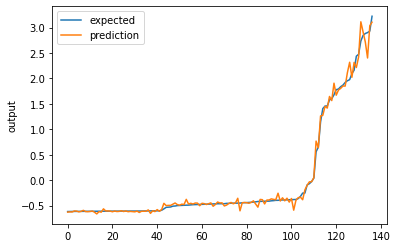

In [385]:
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))      # try changing 100 to 10
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=500)

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)

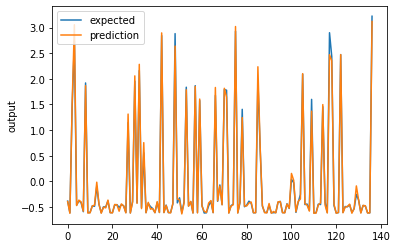

In [361]:
chart_regression(pred.flatten(),y_test,sort=False)